In [1]:
import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from PIL import Image,ImageFile
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from torch.utils.data import Dataset, DataLoader
import copy
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import f1_score

warnings.filterwarnings('ignore')
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
train_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.OneOf([
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=20),
        ], p=1),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [4]:
path = "C:/Users/Vladimir/Downloads/train_dataset_train_data_minprirodi/train_data_minprirodi"


data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
      

df = pd.DataFrame(data) 
# df.loc[df['labels'] == 'norm_animal', 'labels'] = 'norm_no_animal'

# df.loc[df['labels'] == 'normanimal', 'labels'] = 'norm__animal'
# df.loc[df['labels'] == 'norm_no_animal', 'labels'] = 'norm_noanimal'


print(df)

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])


print("-------------Fetch files into a data frame-----------")
print(df)
print("-------------Path to an image file------------------")
print(df.loc[0]['imgpath']) 
print("-----------Number of images per category--------------")
print(df.labels.value_counts())  

                                                imgpath  labels
0     C:/Users/Vladimir/Downloads/train_dataset_trai...   empty
1     C:/Users/Vladimir/Downloads/train_dataset_trai...   empty
2     C:/Users/Vladimir/Downloads/train_dataset_trai...   empty
3     C:/Users/Vladimir/Downloads/train_dataset_trai...   empty
4     C:/Users/Vladimir/Downloads/train_dataset_trai...   empty
...                                                 ...     ...
3364  C:/Users/Vladimir/Downloads/train_dataset_trai...  normal
3365  C:/Users/Vladimir/Downloads/train_dataset_trai...  normal
3366  C:/Users/Vladimir/Downloads/train_dataset_trai...  normal
3367  C:/Users/Vladimir/Downloads/train_dataset_trai...  normal
3368  C:/Users/Vladimir/Downloads/train_dataset_trai...  normal

[3369 rows x 2 columns]
-------------Fetch files into a data frame-----------
                                                imgpath  labels  \
0     C:/Users/Vladimir/Downloads/train_dataset_trai...   empty   
1     C:/Users/Vlad

In [5]:
train_df, valid_df = train_test_split(df,  train_size= 0.80 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print("#############Train Split###################")
print(train_df.head(5))
print(train_df.shape)
print("#############Test Split###################")
print(valid_df.head(5))
print(valid_df.shape)

#############Train Split###################
                                             imgpath  labels  encoded_labels
0  C:/Users/Vladimir/Downloads/train_dataset_trai...   empty               0
1  C:/Users/Vladimir/Downloads/train_dataset_trai...   empty               0
2  C:/Users/Vladimir/Downloads/train_dataset_trai...  normal               1
3  C:/Users/Vladimir/Downloads/train_dataset_trai...   empty               0
4  C:/Users/Vladimir/Downloads/train_dataset_trai...  normal               1
(2695, 3)
#############Test Split###################
                                             imgpath  labels  encoded_labels
0  C:/Users/Vladimir/Downloads/train_dataset_trai...  normal               1
1  C:/Users/Vladimir/Downloads/train_dataset_trai...   empty               0
2  C:/Users/Vladimir/Downloads/train_dataset_trai...  normal               1
3  C:/Users/Vladimir/Downloads/train_dataset_trai...  normal               1
4  C:/Users/Vladimir/Downloads/train_dataset_trai...   e

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 32
num_epochs = 25
num_classes = 2

In [7]:

class flower_Dataset(Dataset):
    def __init__(self, img_data,transform=None):
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = self.img_data.loc[index]['imgpath']
        image = Image.open(img_name)
        image = np.array(image)
        label = torch.tensor(self.img_data.loc[index]['encoded_labels'])
      
        if self.transform is not None:
            image = self.transform(image=image)['image']
                        
        return image, label
        

training_data = flower_Dataset(train_df, train_transform)
validatin_data = flower_Dataset(valid_df, test_transform)
    

In [8]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(validatin_data, batch_size=batch_size , shuffle=True)

print(">> Number of Train Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(train_dataloader.dataset) , batch_size , len(train_dataloader)))
print(">> Number of Validiation Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(test_dataloader.dataset) , batch_size , len(test_dataloader)))
onebatch = iter(train_dataloader)
train_features, train_labels = next(onebatch)
print("----------Batch Shape--------")
print(f"Feature batch shape: {train_features.size()}")
print("----------Labels Shape--------")
print(f"Labels batch shape: {train_labels.size()}")

>> Number of Train Data : 2695 -- Batch Size : 32 -- Number of Batch : 85 
>> Number of Validiation Data : 674 -- Batch Size : 32 -- Number of Batch : 22 
----------Batch Shape--------
Feature batch shape: torch.Size([32, 3, 224, 224])
----------Labels Shape--------
Labels batch shape: torch.Size([32])


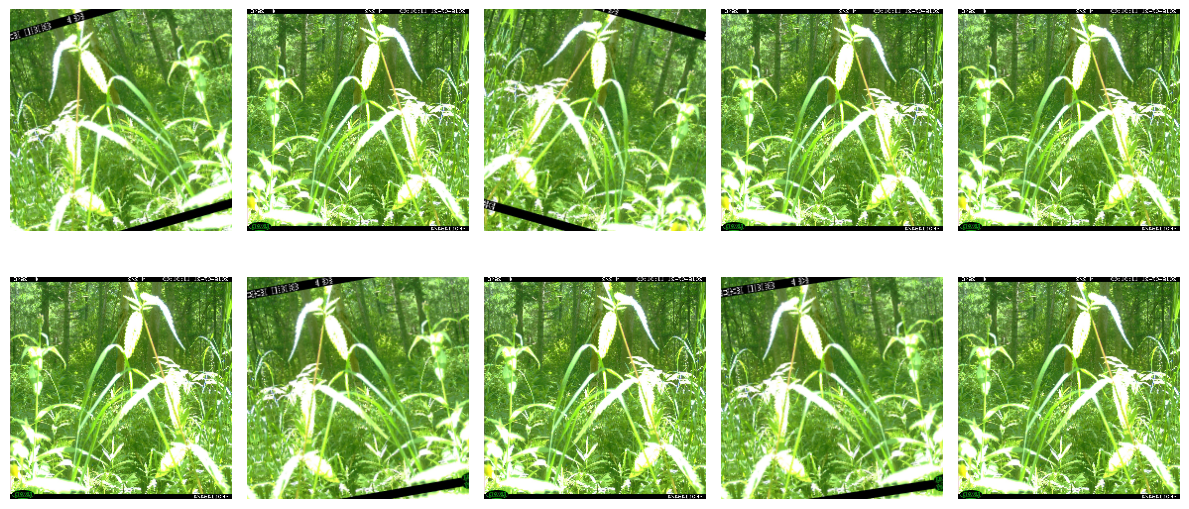

In [9]:
def visualize_augmentations(dataset, idx=8, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

visualize_augmentations(training_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


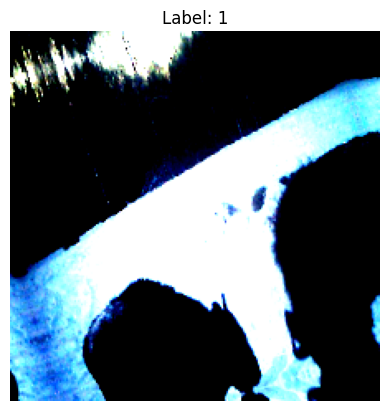

In [10]:
random_index = random.randint(0, len(training_data) - 1)

image, label = training_data[random_index]

image = image.permute(1, 2, 0)

plt.imshow(image)
plt.title("Label: {}".format(label))
plt.axis('off')
plt.show()

In [11]:
def early_stopping(val_loss):
    global best_loss, early_stopping_counter
    if val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            return True
    return False
def save_checkpoint(model, optimizer, epoch, val_loss, model_name):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss
    }
    torch.save(checkpoint, f'best_{model_name}.pth')

In [12]:
resnet = models.resnext101_32x8d(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.01)

In [10]:
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.01)

In [13]:
swin = models.swin_v2_s(pretrained=True)
for param in swin.parameters():
    param.requires_grad = False
swin.head = torch.nn.Linear(swin.head.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(swin.parameters(), lr=0.01)

In [9]:
efficientNet = models.efficientnet_v2_m(pretrained=True)
for param in efficientNet.parameters():
    param.requires_grad = False
efficientNet.classifier = torch.nn.Linear(1280, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientNet.parameters(), lr=0.01)

In [34]:
swin

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=3, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='

In [14]:
best_accuracy = 0
best_loss = float('inf')
early_stopping_counter = 0
patience = 4

for epoch in range(num_epochs):
    running_loss = 0.0
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for images, labels in progress_bar:
        # images, labels = images.to(device), labels.to(device)
        # resnet = resnet.to(device)

        optimizer.zero_grad()
        
        images = images.to(device)  # Исправленная строка
        labels = labels.to(device).long()
        resnet = resnet.to(device)
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        progress_bar.set_postfix({"Loss": running_loss / (len(progress_bar) + 1e-6)})

    epoch_loss = running_loss / len(train_dataloader)
    epoch_loss = round(epoch_loss, 3)
    print(f"Epoch {epoch+1} Loss: {epoch_loss}")
    
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0

        all_labels = []
        all_predictions = []
        
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device).long()
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())


            random_index = random.randint(0, images.size(0) - 1)
            prediction = predicted[random_index].item()
            label = labels[random_index].item()

        val_loss /= len(test_dataloader)
        val_loss = round(val_loss, 3)
        accuracy = correct / total

        f1 = f1_score(all_labels, all_predictions, average='macro')

        print(f"Validation Loss: {val_loss}")
        print(f"Validation Accuracy: {accuracy}")
        print(f"Validation F1 Score: {f1}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            save_checkpoint(resnet, optimizer, epoch, val_loss, 'efficient')
        
        if early_stopping(val_loss):
            print("Early Stopping!")
            break

Epoch 1 Loss: 0.754
Validation Loss: 0.739
Validation Accuracy: 0.37833827893175076
Validation F1 Score: 0.3773390629857545


Epoch 2 Loss: 0.75
Validation Loss: 0.733
Validation Accuracy: 0.39020771513353114
Validation F1 Score: 0.3894967900614219


Epoch 3 Loss: 0.75
Validation Loss: 0.737
Validation Accuracy: 0.4050445103857567
Validation F1 Score: 0.4046657723679312


Epoch 4 Loss: 0.75
Validation Loss: 0.735
Validation Accuracy: 0.39020771513353114
Validation F1 Score: 0.38961516850837863


Epoch 5 Loss: 0.751
Validation Loss: 0.742
Validation Accuracy: 0.39317507418397624
Validation F1 Score: 0.392467608601269


Epoch 6 Loss: 0.752
Validation Loss: 0.735
Validation Accuracy: 0.41097922848664686
Validation F1 Score: 0.4106873456946466
Early Stopping!


In [13]:
checkpoint = torch.load('best_efficient.pth')
resnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
with torch.no_grad():
    correct = 0
    total = 0

    all_labels = []
    all_predictions = []

    for images, labels in test_dataloader:
        images = images.to(device)  # Исправленная строка
        labels = labels.to(device)  # Исправленная строка
        resnet = resnet.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        random_index = random.randint(0, images.size(0) - 1)
        prediction = predicted[random_index].item()
        label = labels[random_index].item()

    accuracy = correct / total
    f1 = f1_score(all_labels, all_predictions, average='macro')
    print(f"Test Accuracy: {accuracy}")
    print(f"Test F1 Score: {f1}")
    print(f"{correct}/{total}")

total_params = sum(p.numel() for p in resnet.parameters() if p.requires_grad)
print(f"Total resnet Parameters: {total_params}")

Test Accuracy: 0.49622166246851385
Test F1 Score: 0.46562213966510524
197/397
Total resnet Parameters: 4098


# SWIN

In [15]:
optimizer = optim.Adam(swin.parameters(), lr=0.0001)
layersTofreeze = ['features']
for i in reversed(layersTofreeze):
    for j in reversed(swin.get_submodule(i)):
        j.requires_grad_(True)
        progress_bar = tqdm(train_dataloader, desc=f"", leave=False)
    
    for images, labels in progress_bar:
        # images, labels = images.to(device), labels.to(device)
        # resnet = resnet.to(device)

        optimizer.zero_grad()
        
        images = images.to(device)  # Исправленная строка
        labels = labels.to(device).long()
        swin = swin.to(device)
        outputs = swin(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        progress_bar.set_postfix({"Loss": running_loss / (len(progress_bar) + 1e-6)})

    epoch_loss = running_loss / len(train_dataloader)
    epoch_loss = round(epoch_loss, 3)
    print(f"Loss: {epoch_loss}")
    
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0

        all_labels = []
        all_predictions = []
        
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device).long()
            outputs = swin(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            random_index = random.randint(0, images.size(0) - 1)
            prediction = predicted[random_index].item()
            label = labels[random_index].item()

        val_loss /= len(test_dataloader)
        val_loss = round(val_loss, 3)
        accuracy = correct / total
        f1 = f1_score(all_labels, all_predictions, average='macro')
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            save_checkpoint(swin, optimizer, epoch, val_loss, 'efficient')

        print(f"Validation Loss: {val_loss}")
        print(f"Validation Accuracy: {accuracy}")
        print(f"Validation F1 Score: {f1}")

Loss: 0.852
Validation Loss: 0.048
Validation Accuracy: 0.9866468842729971
Validation F1 Score: 0.9866065218687281


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


Test Accuracy: 0.9851632047477745
Test F1 Score: 0.9851158928697619
664/674


IndexError: index 2 is out of bounds for dimension 0 with size 2

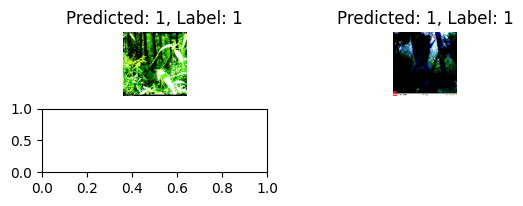

In [16]:
checkpoint = torch.load('best_efficient.pth')
swin.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
with torch.no_grad():
    correct = 0
    total = 0
    labels_list = []
    predicted_list = []

    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        swin = swin.to(device)
        outputs = swin(images)
        _, predicted = torch.max(outputs.data, 1)

        for i in range(images.size(0)):
            labels_list.append(labels[i].item())
            predicted_list.append(predicted[i].item())
            
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    accuracy = correct / total
    f1 = f1_score(labels_list, predicted_list, average='macro')
    print(f"Test Accuracy: {accuracy}")
    print(f"Test F1 Score: {f1}")
    print(f"{correct}/{total}")


    
# Выводим информацию для каждого изображения
    for i in range(10):
        plt.subplot(5, 2, i+1)
        plt.imshow(images[i].cpu().permute(1, 2, 0))
        plt.title(f"Predicted: {predicted_list[i]}, Label: {labels_list[i]}")
        plt.axis('off')

    plt.show()

total_params = sum(p.numel() for p in swin.parameters() if p.requires_grad)
print(f"Total swin_t Parameters: {total_params}")

In [24]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models import swin_v2_s

# Define transformation for the image
test_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dictionary for class labels
class_labels = {
    0: 'empty',
    1: 'normal'
}

def get_classify_model():
    model = swin_v2_s(pretrained=False)
    model.head = nn.Linear(model.head.in_features, 2)  # Обновляем последний слой для 2 классов
    checkpoint = torch.load('images_class.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)  # Ensure the entire model is on the same device
    model.eval()
    return model

def tensor_from_images(image):
    image = test_transform(image=np.array(image))['image'].unsqueeze(0).to(device)
    return image

def predict(image_path, model):
    image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB mode
    tensor = tensor_from_images(image)
    
    with torch.no_grad():
        outputs = model(tensor)
        _, preds = torch.max(outputs, 1)
        predicted_class = preds.item()
    
    return class_labels[predicted_class]


In [25]:
def predict_images_from_folder(folder_path):
    model = get_classify_model()
    results = []
    
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        
        if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            predicted_class = predict(image_path, model)
            results.append((image_name, predicted_class))
            print(f'{image_name} - {predicted_class}')
    
    return results

In [26]:
folder_path = 'D:/hackKalin/dataparse/test'
results = predict_images_from_folder(folder_path)

3000169.jpg - empty
3000402.jpg - empty
3001814.jpg - empty
3001960.jpg - empty
3002029.jpg - empty
3002446.jpg - empty
3005109.jpg - empty
3006307.jpg - empty
3007229.jpg - empty
__10.JPG - normal
__11.JPG - normal
__12.JPG - normal
__13.JPG - normal
__14.JPG - empty
__15.JPG - empty
__16.JPG - empty
__18.JPG - normal
__19.JPG - normal
__20.JPG - normal
__3.JPG - normal
__4.JPG - empty
__5.JPG - empty
__6.JPG - empty
__7.JPG - empty
__8.JPG - empty
__9.JPG - empty
___19.JPG - empty
___20.JPG - empty
___21.JPG - empty


In [24]:
image_path = 'D:/hackKalin/class_data/bad/1999067_1_class0.jpg'
predicted_class = predict(image_path)
print(f'The predicted class is: {predicted_class}')

The predicted class is: bad


In [28]:
image_path = 'D:/hackKalin/train_strogo/norm_animal/__110.jpg'
predicted_class = predict(image_path)
print(f'The predicted class is: {predicted_class}')

The predicted class is: good
